# FedFromScratch
## A local implementation of the Federated Learning algorithm (FedAvg) in plain torch


## Introduction

Federated Learning is a distributed machine learning approach that allows training a global model across multiple devices or servers holding local data samples, without exchanging them. The idea is to train a global model by averaging the local models of each device. This way, the data remains on the device, and only the model is shared. This approach is particularly useful when the data is sensitive and cannot be shared, or when the data is too large to be centralized.

More formally, the Federated Learning algorithm can be described as follows:

1. Initialize the global model parameters $\theta$.
2. For each round $r$ in $1, \ldots, R$:
    1. For each `client` $k$ in $1, \ldots, K$:
        1. Send the global model parameters $\theta$ to device $k$.
        2. Train the local models $\theta_k$ using the local data $D_k$ (possibly non iid): $\theta_k \leftarrow \eta_k\nabla_\theta\mathcal{L}(\mathbf{y}, \mathbf{l})$.
        3. Send the local model parameters $\theta_k$ to the server.
    2. Update the global model parameters $\theta \leftarrow \theta = \frac{1}{K} \sum_{k=1}^K \theta_k$
3. Return the global model parameters $\theta$.

In this notebook, we will implement the Federated Learning algorithm in plain torch, using the MNIST dataset. We will use a simple CNN model, and we will train it emulating clients behavior by running each client on a separate process through Joblib. Implementation details and code are proided in the "models.py" file.



## Basic setup and "monolithic" training of the model

In the following cell, we will define the basic setup for the training of the model. We will define the model, the loss function, the optimizer, and the data loaders. We will train the model on the whole dataset to have a baseline to compare the Federated Learning approach.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


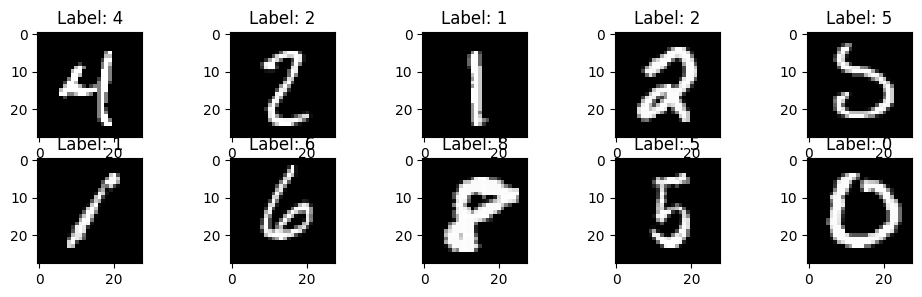

In [9]:
# set autoreload
%load_ext autoreload
%autoreload 2

from models import MNISTConvNet, MNISTFederatedServer, get_mnist_dataloader, init_clients, MNISTConvNetTrainer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np

# firstly, we create the dataloader for the MNIST dataset
train, val, test = get_mnist_dataloader(64)

# print some sample images from the training set with matplotlib
# just some code to show the usual images we all know well!
fig, axs = plt.subplots(2, 5, figsize=(12, 3))
for i, ax in enumerate(axs.flat):
    ax.imshow(train.dataset[i][0].squeeze(), cmap='gray')
    ax.set_title(f'Label: {train.dataset[i][1]}')

In [3]:
trainer = MNISTConvNetTrainer(
    MNISTConvNet(), 
    train,          # training set
    val,            # using validation set
    device='mps',   # training using Apple's Metal Performance Shaders, you can also use 'cuda' or 'cpu'
    weight_decay=1e-5,
    lr=0.01
)   

# training the model on the whole training sety (50000 samples), for 10 epochs.
# Optimizer is Adam, with a learning rate of 0.001 and a weight decay of 0.0001
# since this is a very simple task, we can safely ignore a proper model selection procedure.
trainer.train(16)
loss, accuracy = trainer.test(test)

print(f'Test loss: {loss:.4f}, accuracy: {accuracy:.4f}')

Model created and moved to mps


  6%|██▊                                         | 1/16 [00:05<01:29,  5.99s/it]

Epoch 1, Loss: 1.9405596638884386, Accuracy: 0.35716, Val Loss: 0.44362732768058777, Val Acc: 0.8711


 12%|█████▌                                      | 2/16 [00:11<01:23,  5.98s/it]

Epoch 2, Loss: 0.27335481913498294, Accuracy: 0.91702, Val Loss: 0.17440347373485565, Val Acc: 0.9477


 19%|████████▎                                   | 3/16 [00:17<01:17,  5.97s/it]

Epoch 3, Loss: 0.16551537211755735, Accuracy: 0.9495, Val Loss: 0.1500484198331833, Val Acc: 0.9542


 25%|███████████                                 | 4/16 [00:23<01:11,  5.98s/it]

Epoch 4, Loss: 0.1331484581122313, Accuracy: 0.95894, Val Loss: 0.12709951400756836, Val Acc: 0.9601


 31%|█████████████▊                              | 5/16 [00:29<01:05,  5.98s/it]

Epoch 5, Loss: 0.1101518206469848, Accuracy: 0.965, Val Loss: 0.08778044581413269, Val Acc: 0.9726


 38%|████████████████▌                           | 6/16 [00:35<00:59,  5.98s/it]

Epoch 6, Loss: 0.09784905068919329, Accuracy: 0.96948, Val Loss: 0.1044091060757637, Val Acc: 0.967


 44%|███████████████████▎                        | 7/16 [00:41<00:53,  5.98s/it]

Epoch 7, Loss: 0.08905594135203478, Accuracy: 0.97212, Val Loss: 0.08353012055158615, Val Acc: 0.9745


 50%|██████████████████████                      | 8/16 [00:47<00:47,  5.98s/it]

Epoch 8, Loss: 0.0796919374010952, Accuracy: 0.97514, Val Loss: 0.08617401868104935, Val Acc: 0.9721


 56%|████████████████████████▊                   | 9/16 [00:53<00:41,  5.97s/it]

Epoch 9, Loss: 0.07447032620558691, Accuracy: 0.97694, Val Loss: 0.06579943001270294, Val Acc: 0.9788


 62%|██████████████████████████▉                | 10/16 [00:59<00:35,  5.98s/it]

Epoch 10, Loss: 0.06979582982573687, Accuracy: 0.97824, Val Loss: 0.061001911759376526, Val Acc: 0.9807


 69%|█████████████████████████████▌             | 11/16 [01:05<00:29,  5.97s/it]

Epoch 11, Loss: 0.06546405416346439, Accuracy: 0.97926, Val Loss: 0.06383074820041656, Val Acc: 0.9798


 75%|████████████████████████████████▎          | 12/16 [01:11<00:23,  5.96s/it]

Epoch 12, Loss: 0.06011841846498973, Accuracy: 0.98106, Val Loss: 0.057774920016527176, Val Acc: 0.9811


 81%|██████████████████████████████████▉        | 13/16 [01:17<00:17,  5.96s/it]

Epoch 13, Loss: 0.058601386570002495, Accuracy: 0.9816, Val Loss: 0.05636875331401825, Val Acc: 0.9823


 88%|█████████████████████████████████████▋     | 14/16 [01:23<00:11,  5.95s/it]

Epoch 14, Loss: 0.05600207090935172, Accuracy: 0.98214, Val Loss: 0.07536415010690689, Val Acc: 0.9767


 94%|████████████████████████████████████████▎  | 15/16 [01:29<00:05,  5.96s/it]

Epoch 15, Loss: 0.05235358287626163, Accuracy: 0.98344, Val Loss: 0.05204688385128975, Val Acc: 0.9837


100%|███████████████████████████████████████████| 16/16 [01:35<00:00,  5.97s/it]

Epoch 16, Loss: 0.050090836584055914, Accuracy: 0.98406, Val Loss: 0.0516400970518589, Val Acc: 0.9832


Test loss: 0.0415, accuracy: 0.9859


### We now have a solid baseline model that we will use to compare the performance of the Federated Learning approach.
Without model selelction and further tuning, we reached a CE loss of $0.0415$ and an accuracy of $98.59%$ on the blind test set.

Let's now test the Federated Learning approach. We will first test it on 10 clients, although the number of clients can be easily increased by changing the `n_clients` parameter.

We will train the same model architecture on each client, and according to the algorithm, we will average the weights of the models at the end of each round.  

Each client will draw a subset of 512 data points from the training set, and we will train the model for 5 epochs on each client. We will run 64 rounds of training (64 global updates), with 10 jobs running in parallel (my machine has 10 cores...): in this case, we are assuming that the data is IID across the clients; we will further release this assumption. These parameers reflect those of the original FedAvg paper.

> Note: with this simple setup, we will not implement any advanced techniques to improve the performance of the model, such as learning rate scheduling, early stopping, or data augmentation. The goal is to provide a simple implementation of the Federated Learning algorithm in plain torch. 

> Note: in the spirit of FedAvg, the server is not aware of the data distribution on the clients.

In [3]:
model5e10c  = MNISTConvNet()
server5e10c = MNISTFederatedServer(model=model5e10c, test_loader=val)


# we first create 10 clients
clients = init_clients(
    num_clients=10, 
    local_epochs=5, 
    lr=1e-2, 
    train_dataset=train, 
    n_samples=512, 
    device='mps', 
    weight_decay=1e-6, 
    sample_method='iid'
)

loss_5, acc_5 = server5e10c.start_train(clients, n_rounds=64, n_jobs=10)

# save history
# save history
with open('../histories/history_5e10c.pkl', 'wb') as f:
    pickle.dump({'loss': loss_5, 'accuracy': acc_5}, f)

> Client 0 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 1 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 2 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 3 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 4 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 5 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 6 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 7 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 8 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06
> Client 9 created, lr: 0.01, epochs: 5, samples: 512, device: mps, weight_decay: 1e-06


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 113.45it/s]


Aggregating 10 local states

Round 0, Test Loss: 2.2976973056793213, Test Acc: 0.1262


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1211.95it/s]


Aggregating 10 local states

Round 1, Test Loss: 2.285429000854492, Test Acc: 0.2391


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8459.67it/s]


Aggregating 10 local states

Round 2, Test Loss: 2.2618837356567383, Test Acc: 0.3389


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13756.33it/s]


Aggregating 10 local states

Round 3, Test Loss: 2.204603910446167, Test Acc: 0.2748


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7998.29it/s]


Aggregating 10 local states

Round 4, Test Loss: 1.975772500038147, Test Acc: 0.5209


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8552.82it/s]


Aggregating 10 local states

Round 5, Test Loss: 1.1487970352172852, Test Acc: 0.723


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16156.80it/s]


Aggregating 10 local states

Round 6, Test Loss: 0.6884174346923828, Test Acc: 0.8205


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12869.91it/s]


Aggregating 10 local states

Round 7, Test Loss: 0.5011142492294312, Test Acc: 0.8627


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10039.02it/s]


Aggregating 10 local states

Round 8, Test Loss: 0.3930143415927887, Test Acc: 0.892


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13512.58it/s]


Aggregating 10 local states

Round 9, Test Loss: 0.33106523752212524, Test Acc: 0.907


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13302.58it/s]


Aggregating 10 local states

Round 10, Test Loss: 0.2857859432697296, Test Acc: 0.9194


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13551.87it/s]


Aggregating 10 local states

Round 11, Test Loss: 0.2528824806213379, Test Acc: 0.9236


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 6667.15it/s]


Aggregating 10 local states

Round 12, Test Loss: 0.24153827130794525, Test Acc: 0.9268


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9679.91it/s]


Aggregating 10 local states

Round 13, Test Loss: 0.21290583908557892, Test Acc: 0.9355


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10163.08it/s]


Aggregating 10 local states

Round 14, Test Loss: 0.20246751606464386, Test Acc: 0.9381


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13893.02it/s]


Aggregating 10 local states

Round 15, Test Loss: 0.18648523092269897, Test Acc: 0.9433


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13810.68it/s]


Aggregating 10 local states

Round 16, Test Loss: 0.1771731823682785, Test Acc: 0.9464


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14619.39it/s]


Aggregating 10 local states

Round 17, Test Loss: 0.1696169227361679, Test Acc: 0.947


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11641.14it/s]


Aggregating 10 local states

Round 18, Test Loss: 0.16458937525749207, Test Acc: 0.948


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9960.35it/s]


Aggregating 10 local states

Round 19, Test Loss: 0.16020074486732483, Test Acc: 0.949


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11187.79it/s]


Aggregating 10 local states

Round 20, Test Loss: 0.15523166954517365, Test Acc: 0.951


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16150.57it/s]


Aggregating 10 local states

Round 21, Test Loss: 0.1454544961452484, Test Acc: 0.9547


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15224.33it/s]


Aggregating 10 local states

Round 22, Test Loss: 0.1406429409980774, Test Acc: 0.9558


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11481.81it/s]


Aggregating 10 local states

Round 23, Test Loss: 0.1381947100162506, Test Acc: 0.9561


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9362.29it/s]


Aggregating 10 local states

Round 24, Test Loss: 0.134669691324234, Test Acc: 0.9571


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14037.16it/s]


Aggregating 10 local states

Round 25, Test Loss: 0.13014639914035797, Test Acc: 0.9586


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11314.55it/s]


Aggregating 10 local states

Round 26, Test Loss: 0.1302359402179718, Test Acc: 0.958


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9082.51it/s]


Aggregating 10 local states

Round 27, Test Loss: 0.12537111341953278, Test Acc: 0.9592


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11372.84it/s]


Aggregating 10 local states

Round 28, Test Loss: 0.12188982218503952, Test Acc: 0.9614


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12132.79it/s]


Aggregating 10 local states

Round 29, Test Loss: 0.12177282571792603, Test Acc: 0.9612


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7955.81it/s]


Aggregating 10 local states

Round 30, Test Loss: 0.11828289926052094, Test Acc: 0.9607


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9532.51it/s]


Aggregating 10 local states

Round 31, Test Loss: 0.11749696731567383, Test Acc: 0.9618


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9941.46it/s]


Aggregating 10 local states

Round 32, Test Loss: 0.1145930215716362, Test Acc: 0.9623


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8142.70it/s]


Aggregating 10 local states

Round 33, Test Loss: 0.11324965208768845, Test Acc: 0.9632


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10340.99it/s]


Aggregating 10 local states

Round 34, Test Loss: 0.11346525698900223, Test Acc: 0.9633


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10202.64it/s]


Aggregating 10 local states

Round 35, Test Loss: 0.10983197391033173, Test Acc: 0.9646


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11680.04it/s]


Aggregating 10 local states

Round 36, Test Loss: 0.11194406449794769, Test Acc: 0.9635


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10798.93it/s]


Aggregating 10 local states

Round 37, Test Loss: 0.10465710610151291, Test Acc: 0.9665


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11560.93it/s]


Aggregating 10 local states

Round 38, Test Loss: 0.1054481491446495, Test Acc: 0.9662


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12328.94it/s]


Aggregating 10 local states

Round 39, Test Loss: 0.10185891389846802, Test Acc: 0.9676


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9240.59it/s]


Aggregating 10 local states

Round 40, Test Loss: 0.10271000862121582, Test Acc: 0.9666


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7771.55it/s]


Aggregating 10 local states

Round 41, Test Loss: 0.09859311580657959, Test Acc: 0.9686


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12610.66it/s]


Aggregating 10 local states

Round 42, Test Loss: 0.0973983108997345, Test Acc: 0.9678


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10868.89it/s]


Aggregating 10 local states

Round 43, Test Loss: 0.09686106443405151, Test Acc: 0.969


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10527.87it/s]


Aggregating 10 local states

Round 44, Test Loss: 0.09444717317819595, Test Acc: 0.9698


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 14329.70it/s]


Aggregating 10 local states

Round 45, Test Loss: 0.09677106887102127, Test Acc: 0.968


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9727.05it/s]


Aggregating 10 local states

Round 46, Test Loss: 0.09438923746347427, Test Acc: 0.9698


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9450.89it/s]


Aggregating 10 local states

Round 47, Test Loss: 0.09648869931697845, Test Acc: 0.9689


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8176.03it/s]


Aggregating 10 local states

Round 48, Test Loss: 0.09297299385070801, Test Acc: 0.9699


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 17764.95it/s]


Aggregating 10 local states

Round 49, Test Loss: 0.09063799679279327, Test Acc: 0.9716


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12527.79it/s]


Aggregating 10 local states

Round 50, Test Loss: 0.09052512794733047, Test Acc: 0.9707


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13021.74it/s]


Aggregating 10 local states

Round 51, Test Loss: 0.09185361862182617, Test Acc: 0.971


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16313.90it/s]


Aggregating 10 local states

Round 52, Test Loss: 0.08822380006313324, Test Acc: 0.9729


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9502.27it/s]


Aggregating 10 local states

Round 53, Test Loss: 0.08717263489961624, Test Acc: 0.9728


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10954.05it/s]


Aggregating 10 local states

Round 54, Test Loss: 0.08735272288322449, Test Acc: 0.9722


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7177.11it/s]


Aggregating 10 local states

Round 55, Test Loss: 0.08609943836927414, Test Acc: 0.9718


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12221.17it/s]


Aggregating 10 local states

Round 56, Test Loss: 0.08652017265558243, Test Acc: 0.9724


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10265.06it/s]


Aggregating 10 local states

Round 57, Test Loss: 0.08403150737285614, Test Acc: 0.9736


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12358.00it/s]


Aggregating 10 local states

Round 58, Test Loss: 0.08447954803705215, Test Acc: 0.9737


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15431.58it/s]


Aggregating 10 local states

Round 59, Test Loss: 0.0843445435166359, Test Acc: 0.9735


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11748.75it/s]


Aggregating 10 local states

Round 60, Test Loss: 0.08522964268922806, Test Acc: 0.974


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12267.63it/s]


Aggregating 10 local states

Round 61, Test Loss: 0.08230715990066528, Test Acc: 0.9742


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10727.12it/s]


Aggregating 10 local states

Round 62, Test Loss: 0.08078344911336899, Test Acc: 0.9752


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9841.16it/s]


Aggregating 10 local states

Round 63, Test Loss: 0.08008744567632675, Test Acc: 0.9752


In [7]:
# test the model on the test set
loss, accuracy = server5e10c.test()
print(f'Test loss: {loss:.4f}, accuracy: {accuracy:.4f}')

Test loss: 0.0780, accuracy: 0.9762


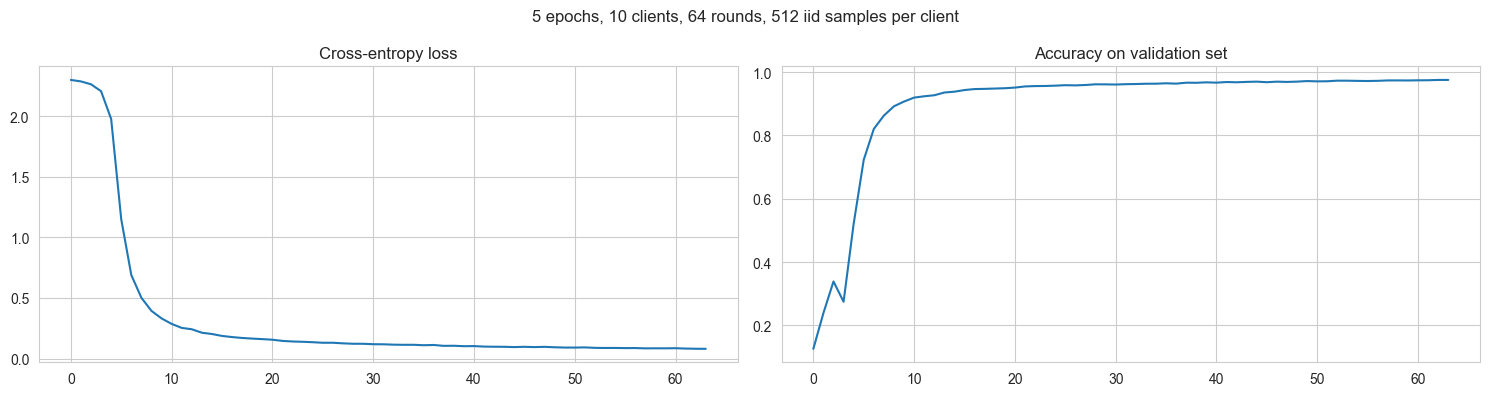

In [25]:
# plot history with seaborn

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(loss_5)
axs[0].set_title('Cross-entropy loss')
axs[1].plot(acc_5)
axs[1].set_title('Accuracy on validation set')

# set suptitle
fig.suptitle('5 epochs, 10 clients, 64 rounds, 512 iid samples per client')
fig.tight_layout()
plt.show()

### It works! The model trained with Federated Learning reached a CE loss of $0.0780$ and an accuracy of $97.62\%$ on the blind test set.
(I think that there is still some margin for improvement, but the results are already quite good!)


### Now, let's test federated learning with many clients, each one sampling very few data points from the training set. Again, the distribution is iid across the clients.
This expetiment aims to simulate a more realistic scenario where the data samples are few and distributed across many clients. We will use 128 clients, each one drawing 32 data points from the training set. We will train the model for 5 epochs on each client, and we will run 64 rounds of training with 16 jobs running in parallel.

In [27]:
model5e128c  = MNISTConvNet()
server = MNISTFederatedServer(model=model5e128c, test_loader=val)

clients = init_clients(
   num_clients=128,
   local_epochs=5,
   lr=1e-2,
   train_dataset=train,
   n_samples=32,
   device='mps',
   weight_decay=1e-10,
   sample_method='iid'
)

loss5e128c, acc5e128c = server.start_train(clients, n_rounds=128, n_jobs=10)

# save history
with open('history_5e128c.pkl', 'wb') as f:
    pickle.dump({'loss': loss5e128c, 'accuracy': acc5e128c}, f)

> Client 0 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 1 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 2 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 3 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 4 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 5 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 6 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 7 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 8 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 9 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 10 created, lr: 0.01, epochs: 5, samples: 32, device: mps, weight_decay: 1e-10
> Client 11 created, lr: 0.01, epochs: 5, 

100%|█████████████████████████████████████████| 128/128 [00:08<00:00, 14.91it/s]


Aggregating 128 local states

Round 0, Test Loss: 2.3050389289855957, Test Acc: 0.0858


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.20it/s]


Aggregating 128 local states

Round 1, Test Loss: 2.304248094558716, Test Acc: 0.0883


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.15it/s]


Aggregating 128 local states

Round 2, Test Loss: 2.3035104274749756, Test Acc: 0.0908


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.21it/s]


Aggregating 128 local states

Round 3, Test Loss: 2.3028032779693604, Test Acc: 0.0938


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.19it/s]


Aggregating 128 local states

Round 4, Test Loss: 2.302008867263794, Test Acc: 0.0964


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 37.13it/s]


Aggregating 128 local states

Round 5, Test Loss: 2.30118989944458, Test Acc: 0.0994


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.10it/s]


Aggregating 128 local states

Round 6, Test Loss: 2.3003008365631104, Test Acc: 0.1015


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 37.20it/s]


Aggregating 128 local states

Round 7, Test Loss: 2.2993783950805664, Test Acc: 0.1049


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.96it/s]


Aggregating 128 local states

Round 8, Test Loss: 2.298456907272339, Test Acc: 0.108


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.01it/s]


Aggregating 128 local states

Round 9, Test Loss: 2.297525644302368, Test Acc: 0.1104


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.71it/s]


Aggregating 128 local states

Round 10, Test Loss: 2.2965939044952393, Test Acc: 0.1138


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.49it/s]


Aggregating 128 local states

Round 11, Test Loss: 2.2956085205078125, Test Acc: 0.1169


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.12it/s]


Aggregating 128 local states

Round 12, Test Loss: 2.2946033477783203, Test Acc: 0.1179


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.94it/s]


Aggregating 128 local states

Round 13, Test Loss: 2.2936513423919678, Test Acc: 0.123


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.26it/s]


Aggregating 128 local states

Round 14, Test Loss: 2.2925946712493896, Test Acc: 0.1265


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.92it/s]


Aggregating 128 local states

Round 15, Test Loss: 2.291550397872925, Test Acc: 0.1333


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.18it/s]


Aggregating 128 local states

Round 16, Test Loss: 2.2904915809631348, Test Acc: 0.1438


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.29it/s]


Aggregating 128 local states

Round 17, Test Loss: 2.289393424987793, Test Acc: 0.1499


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.58it/s]


Aggregating 128 local states

Round 18, Test Loss: 2.288208484649658, Test Acc: 0.1624


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.48it/s]


Aggregating 128 local states

Round 19, Test Loss: 2.286975383758545, Test Acc: 0.1733


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.20it/s]


Aggregating 128 local states

Round 20, Test Loss: 2.2858333587646484, Test Acc: 0.1817


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.89it/s]


Aggregating 128 local states

Round 21, Test Loss: 2.2845001220703125, Test Acc: 0.1964


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.22it/s]


Aggregating 128 local states

Round 22, Test Loss: 2.2831666469573975, Test Acc: 0.2098


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.05it/s]


Aggregating 128 local states

Round 23, Test Loss: 2.281670331954956, Test Acc: 0.2281


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.58it/s]


Aggregating 128 local states

Round 24, Test Loss: 2.2802114486694336, Test Acc: 0.2521


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.25it/s]


Aggregating 128 local states

Round 25, Test Loss: 2.278733253479004, Test Acc: 0.2716


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.54it/s]


Aggregating 128 local states

Round 26, Test Loss: 2.2771799564361572, Test Acc: 0.2853


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.19it/s]


Aggregating 128 local states

Round 27, Test Loss: 2.27545428276062, Test Acc: 0.2982


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.04it/s]


Aggregating 128 local states

Round 28, Test Loss: 2.2737061977386475, Test Acc: 0.3103


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.17it/s]


Aggregating 128 local states

Round 29, Test Loss: 2.271806478500366, Test Acc: 0.326


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.60it/s]


Aggregating 128 local states

Round 30, Test Loss: 2.2698915004730225, Test Acc: 0.3413


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.04it/s]


Aggregating 128 local states

Round 31, Test Loss: 2.2678511142730713, Test Acc: 0.3662


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.86it/s]


Aggregating 128 local states

Round 32, Test Loss: 2.2656235694885254, Test Acc: 0.3728


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.64it/s]


Aggregating 128 local states

Round 33, Test Loss: 2.263331413269043, Test Acc: 0.3865


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.71it/s]


Aggregating 128 local states

Round 34, Test Loss: 2.26078200340271, Test Acc: 0.4018


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.40it/s]


Aggregating 128 local states

Round 35, Test Loss: 2.258084535598755, Test Acc: 0.4059


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.74it/s]


Aggregating 128 local states

Round 36, Test Loss: 2.255274772644043, Test Acc: 0.4139


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.75it/s]


Aggregating 128 local states

Round 37, Test Loss: 2.2522215843200684, Test Acc: 0.4294


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.86it/s]


Aggregating 128 local states

Round 38, Test Loss: 2.2490131855010986, Test Acc: 0.4406


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.66it/s]


Aggregating 128 local states

Round 39, Test Loss: 2.245418071746826, Test Acc: 0.4456


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.33it/s]


Aggregating 128 local states

Round 40, Test Loss: 2.241554021835327, Test Acc: 0.4531


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.63it/s]


Aggregating 128 local states

Round 41, Test Loss: 2.2370870113372803, Test Acc: 0.4526


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.84it/s]


Aggregating 128 local states

Round 42, Test Loss: 2.232417106628418, Test Acc: 0.4495


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.57it/s]


Aggregating 128 local states

Round 43, Test Loss: 2.227185010910034, Test Acc: 0.4457


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.17it/s]


Aggregating 128 local states

Round 44, Test Loss: 2.2215559482574463, Test Acc: 0.4515


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.47it/s]


Aggregating 128 local states

Round 45, Test Loss: 2.2154548168182373, Test Acc: 0.4565


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.95it/s]


Aggregating 128 local states

Round 46, Test Loss: 2.208616256713867, Test Acc: 0.4637


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.98it/s]


Aggregating 128 local states

Round 47, Test Loss: 2.2006640434265137, Test Acc: 0.456


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.87it/s]


Aggregating 128 local states

Round 48, Test Loss: 2.192230701446533, Test Acc: 0.4584


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.75it/s]


Aggregating 128 local states

Round 49, Test Loss: 2.182187080383301, Test Acc: 0.4514


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.10it/s]


Aggregating 128 local states

Round 50, Test Loss: 2.170748472213745, Test Acc: 0.4427


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.79it/s]


Aggregating 128 local states

Round 51, Test Loss: 2.1581931114196777, Test Acc: 0.4428


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.40it/s]


Aggregating 128 local states

Round 52, Test Loss: 2.1441447734832764, Test Acc: 0.4414


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.12it/s]


Aggregating 128 local states

Round 53, Test Loss: 2.1273112297058105, Test Acc: 0.4292


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.49it/s]


Aggregating 128 local states

Round 54, Test Loss: 2.109672784805298, Test Acc: 0.4474


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.15it/s]


Aggregating 128 local states

Round 55, Test Loss: 2.0882320404052734, Test Acc: 0.4403


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.27it/s]


Aggregating 128 local states

Round 56, Test Loss: 2.06512713432312, Test Acc: 0.4466


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.08it/s]


Aggregating 128 local states

Round 57, Test Loss: 2.0392534732818604, Test Acc: 0.4514


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.28it/s]


Aggregating 128 local states

Round 58, Test Loss: 2.0086517333984375, Test Acc: 0.4502


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.04it/s]


Aggregating 128 local states

Round 59, Test Loss: 1.976413607597351, Test Acc: 0.4761


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.56it/s]


Aggregating 128 local states

Round 60, Test Loss: 1.9395328760147095, Test Acc: 0.4803


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.93it/s]


Aggregating 128 local states

Round 61, Test Loss: 1.8982359170913696, Test Acc: 0.4934


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.83it/s]


Aggregating 128 local states

Round 62, Test Loss: 1.8526897430419922, Test Acc: 0.4899


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.06it/s]


Aggregating 128 local states

Round 63, Test Loss: 1.8050025701522827, Test Acc: 0.5066


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.87it/s]


Aggregating 128 local states

Round 64, Test Loss: 1.7537317276000977, Test Acc: 0.5205


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.37it/s]


Aggregating 128 local states

Round 65, Test Loss: 1.6998450756072998, Test Acc: 0.5392


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.28it/s]


Aggregating 128 local states

Round 66, Test Loss: 1.6442797183990479, Test Acc: 0.5572


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.51it/s]


Aggregating 128 local states

Round 67, Test Loss: 1.5875706672668457, Test Acc: 0.5641


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.55it/s]


Aggregating 128 local states

Round 68, Test Loss: 1.528570532798767, Test Acc: 0.5867


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.46it/s]


Aggregating 128 local states

Round 69, Test Loss: 1.4692258834838867, Test Acc: 0.594


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.16it/s]


Aggregating 128 local states

Round 70, Test Loss: 1.4110045433044434, Test Acc: 0.622


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.88it/s]


Aggregating 128 local states

Round 71, Test Loss: 1.3546628952026367, Test Acc: 0.6292


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 33.96it/s]


Aggregating 128 local states

Round 72, Test Loss: 1.2992268800735474, Test Acc: 0.649


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.84it/s]


Aggregating 128 local states

Round 73, Test Loss: 1.2458497285842896, Test Acc: 0.6568


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.21it/s]


Aggregating 128 local states

Round 74, Test Loss: 1.1962276697158813, Test Acc: 0.6596


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.82it/s]


Aggregating 128 local states

Round 75, Test Loss: 1.1471199989318848, Test Acc: 0.6834


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.38it/s]


Aggregating 128 local states

Round 76, Test Loss: 1.1101810932159424, Test Acc: 0.668


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.18it/s]


Aggregating 128 local states

Round 77, Test Loss: 1.0638411045074463, Test Acc: 0.6909


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.88it/s]


Aggregating 128 local states

Round 78, Test Loss: 1.028745174407959, Test Acc: 0.6886


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.57it/s]


Aggregating 128 local states

Round 79, Test Loss: 0.9932339191436768, Test Acc: 0.7001


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.43it/s]


Aggregating 128 local states

Round 80, Test Loss: 0.962974488735199, Test Acc: 0.7073


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.29it/s]


Aggregating 128 local states

Round 81, Test Loss: 0.9386965036392212, Test Acc: 0.712


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.58it/s]


Aggregating 128 local states

Round 82, Test Loss: 0.9154293537139893, Test Acc: 0.7203


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.60it/s]


Aggregating 128 local states

Round 83, Test Loss: 0.8893446326255798, Test Acc: 0.728


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.64it/s]


Aggregating 128 local states

Round 84, Test Loss: 0.8635344505310059, Test Acc: 0.7354


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.63it/s]


Aggregating 128 local states

Round 85, Test Loss: 0.8470875024795532, Test Acc: 0.7372


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.81it/s]


Aggregating 128 local states

Round 86, Test Loss: 0.8272313475608826, Test Acc: 0.7336


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.08it/s]


Aggregating 128 local states

Round 87, Test Loss: 0.8067633509635925, Test Acc: 0.7479


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.80it/s]


Aggregating 128 local states

Round 88, Test Loss: 0.7832321524620056, Test Acc: 0.7494


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.23it/s]


Aggregating 128 local states

Round 89, Test Loss: 0.7817168235778809, Test Acc: 0.7487


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.23it/s]


Aggregating 128 local states

Round 90, Test Loss: 0.775239884853363, Test Acc: 0.7459


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.23it/s]


Aggregating 128 local states

Round 91, Test Loss: 0.7636304497718811, Test Acc: 0.7523


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.32it/s]


Aggregating 128 local states

Round 92, Test Loss: 0.7340964674949646, Test Acc: 0.7664


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.48it/s]


Aggregating 128 local states

Round 93, Test Loss: 0.7146197557449341, Test Acc: 0.7724


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.78it/s]


Aggregating 128 local states

Round 94, Test Loss: 0.7020881772041321, Test Acc: 0.7788


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.57it/s]


Aggregating 128 local states

Round 95, Test Loss: 0.6912087202072144, Test Acc: 0.7806


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 32.78it/s]


Aggregating 128 local states

Round 96, Test Loss: 0.6780341863632202, Test Acc: 0.7819


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 37.30it/s]


Aggregating 128 local states

Round 97, Test Loss: 0.6674741506576538, Test Acc: 0.7868


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.58it/s]


Aggregating 128 local states

Round 98, Test Loss: 0.6546837687492371, Test Acc: 0.7906


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 37.44it/s]


Aggregating 128 local states

Round 99, Test Loss: 0.6447851657867432, Test Acc: 0.794


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.73it/s]


Aggregating 128 local states

Round 100, Test Loss: 0.6346498131752014, Test Acc: 0.7985


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.35it/s]


Aggregating 128 local states

Round 101, Test Loss: 0.6251562833786011, Test Acc: 0.8014


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.96it/s]


Aggregating 128 local states

Round 102, Test Loss: 0.6147432327270508, Test Acc: 0.8043


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 37.20it/s]


Aggregating 128 local states

Round 103, Test Loss: 0.614248514175415, Test Acc: 0.7993


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 37.76it/s]


Aggregating 128 local states

Round 104, Test Loss: 0.6027953028678894, Test Acc: 0.8091


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.50it/s]


Aggregating 128 local states

Round 105, Test Loss: 0.5946049094200134, Test Acc: 0.812


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.59it/s]


Aggregating 128 local states

Round 106, Test Loss: 0.5877295136451721, Test Acc: 0.8121


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.75it/s]


Aggregating 128 local states

Round 107, Test Loss: 0.5917636752128601, Test Acc: 0.8144


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.91it/s]


Aggregating 128 local states

Round 108, Test Loss: 0.5799745321273804, Test Acc: 0.8116


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.59it/s]


Aggregating 128 local states

Round 109, Test Loss: 0.5724784731864929, Test Acc: 0.82


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.28it/s]


Aggregating 128 local states

Round 110, Test Loss: 0.5614420175552368, Test Acc: 0.8225


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.50it/s]


Aggregating 128 local states

Round 111, Test Loss: 0.5534599423408508, Test Acc: 0.8262


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.77it/s]


Aggregating 128 local states

Round 112, Test Loss: 0.5481306314468384, Test Acc: 0.8232


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.27it/s]


Aggregating 128 local states

Round 113, Test Loss: 0.5443409085273743, Test Acc: 0.8272


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.49it/s]


Aggregating 128 local states

Round 114, Test Loss: 0.5372723340988159, Test Acc: 0.824


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.38it/s]


Aggregating 128 local states

Round 115, Test Loss: 0.529169499874115, Test Acc: 0.8332


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.77it/s]


Aggregating 128 local states

Round 116, Test Loss: 0.5232774019241333, Test Acc: 0.8321


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.33it/s]


Aggregating 128 local states

Round 117, Test Loss: 0.5164456367492676, Test Acc: 0.8364


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.19it/s]


Aggregating 128 local states

Round 118, Test Loss: 0.5097013711929321, Test Acc: 0.84


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.51it/s]


Aggregating 128 local states

Round 119, Test Loss: 0.5031136870384216, Test Acc: 0.8443


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.34it/s]


Aggregating 128 local states

Round 120, Test Loss: 0.5005583763122559, Test Acc: 0.8428


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.92it/s]


Aggregating 128 local states

Round 121, Test Loss: 0.4958035945892334, Test Acc: 0.8418


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.06it/s]


Aggregating 128 local states

Round 122, Test Loss: 0.48979878425598145, Test Acc: 0.8467


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 34.93it/s]


Aggregating 128 local states

Round 123, Test Loss: 0.48169592022895813, Test Acc: 0.8462


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.38it/s]


Aggregating 128 local states

Round 124, Test Loss: 0.4803244173526764, Test Acc: 0.8448


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 37.14it/s]


Aggregating 128 local states

Round 125, Test Loss: 0.474491149187088, Test Acc: 0.8485


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 35.66it/s]


Aggregating 128 local states

Round 126, Test Loss: 0.475066214799881, Test Acc: 0.8497


100%|█████████████████████████████████████████| 128/128 [00:03<00:00, 36.26it/s]


Aggregating 128 local states

Round 127, Test Loss: 0.4750033915042877, Test Acc: 0.844


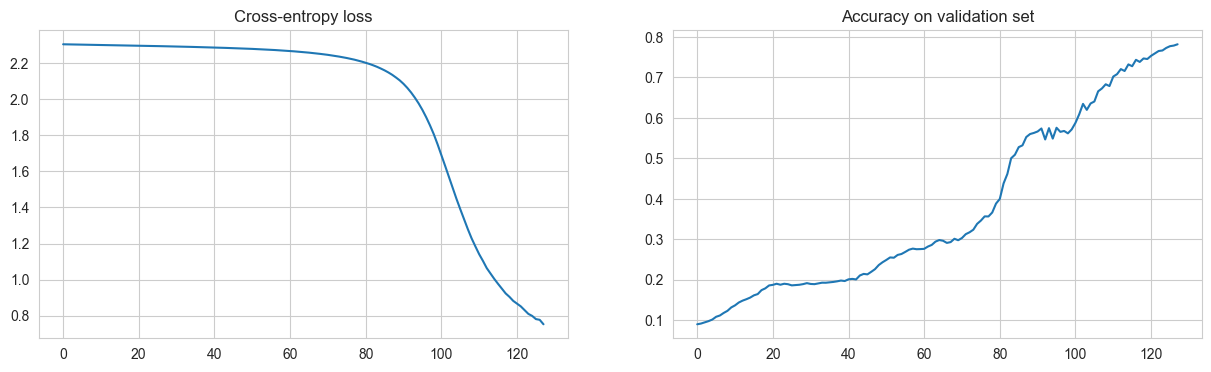

In [29]:
with open('../histories/history_5e128c.pkl', 'rb') as f:
    history = pickle.load(f)

loss5e128c = history['loss']
acc_5e128c = history['accuracy']

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(loss5e128c)
axs[0].set_title('Cross-entropy loss')
 
axs[1].plot(acc_5e128c)
axs[1].set_title('Accuracy on validation set')
plt.show()

## Testing fedavg on MNIST dataset with different numbers of epochs per client

In [7]:
model5e  = MNISTConvNet()
server5e = MNISTFederatedServer(model=model5e, test_loader=val)

clients = init_clients(
   num_clients=5,
   local_epochs=5,
   lr=1e-2,
   train_dataset=train,
   n_samples=256,
   device='mps',
   weight_decay=1e-8,
   sample_method='iid'
)

loss_5e, acc_5e = server5e.start_train(clients, n_rounds=64, n_jobs=8)

# save history
with open('../histories/history_5e5c.pkl', 'wb') as f:
    pickle.dump({'loss': loss_5e, 'accuracy': acc_5e}, f)


model10e  = MNISTConvNet()
server10e = MNISTFederatedServer(model=model10e, test_loader=val)

clients = init_clients(
   num_clients=10,
   local_epochs=5,
   lr=1e-2,
   train_dataset=train,
   n_samples=256,
   device='mps',
   weight_decay=1e-8
)

loss_10e, acc_10e = server10e.start_train(clients, n_rounds=64, n_jobs=8)

# save history
with open('../histories/history_5e10c.pkl', 'wb') as f:
    pickle.dump({'loss': loss_10e, 'accuracy': acc_10e}, f)

model20e  = MNISTConvNet()
server20e = MNISTFederatedServer(model=model20e, test_loader=val)
clients = init_clients(
    num_clients=20,
    local_epochs=5,
    lr=1e-2,
    train_dataset=train,
    n_samples=256,
    device='mps',
    weight_decay=1e-8
)

loss_20e, acc_20e = server20e.start_train(clients, n_rounds=64, n_jobs=8)

# save history
with open('../histories/history_5e20c.pkl', 'wb') as f:
    pickle.dump({'loss': loss_20e, 'accuracy': acc_20e}, f)

> Client 0 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 1 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 2 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 3 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 4 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 109.78it/s]


Aggregating 5 local states

Round 0, Test Loss: 2.300929307937622, Test Acc: 0.0947


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8785.72it/s]


Aggregating 5 local states

Round 1, Test Loss: 2.2986886501312256, Test Acc: 0.094


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6713.03it/s]


Aggregating 5 local states

Round 2, Test Loss: 2.2966909408569336, Test Acc: 0.0967


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8591.36it/s]


Aggregating 5 local states

Round 3, Test Loss: 2.294361114501953, Test Acc: 0.1052


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6385.97it/s]


Aggregating 5 local states

Round 4, Test Loss: 2.291625738143921, Test Acc: 0.1187


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7857.44it/s]


Aggregating 5 local states

Round 5, Test Loss: 2.2883241176605225, Test Acc: 0.1762


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8446.04it/s]


Aggregating 5 local states

Round 6, Test Loss: 2.284304618835449, Test Acc: 0.1861


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12018.06it/s]


Aggregating 5 local states

Round 7, Test Loss: 2.2794101238250732, Test Acc: 0.1392


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9887.56it/s]


Aggregating 5 local states

Round 8, Test Loss: 2.272305727005005, Test Acc: 0.2095


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8263.01it/s]


Aggregating 5 local states

Round 9, Test Loss: 2.262883186340332, Test Acc: 0.3062


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13298.36it/s]


Aggregating 5 local states

Round 10, Test Loss: 2.2482738494873047, Test Acc: 0.3794


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6290.20it/s]


Aggregating 5 local states

Round 11, Test Loss: 2.226529121398926, Test Acc: 0.4303


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7363.60it/s]


Aggregating 5 local states

Round 12, Test Loss: 2.1888208389282227, Test Acc: 0.3481


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9189.97it/s]


Aggregating 5 local states

Round 13, Test Loss: 2.120054006576538, Test Acc: 0.463


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7790.31it/s]


Aggregating 5 local states

Round 14, Test Loss: 1.972926378250122, Test Acc: 0.5469


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8863.70it/s]


Aggregating 5 local states

Round 15, Test Loss: 1.6426383256912231, Test Acc: 0.6126


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 4888.47it/s]


Aggregating 5 local states

Round 16, Test Loss: 1.1819469928741455, Test Acc: 0.7035


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8211.25it/s]


Aggregating 5 local states

Round 17, Test Loss: 0.8457021713256836, Test Acc: 0.7918


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9141.90it/s]


Aggregating 5 local states

Round 18, Test Loss: 0.6711956262588501, Test Acc: 0.8109


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8580.82it/s]


Aggregating 5 local states

Round 19, Test Loss: 0.5674647688865662, Test Acc: 0.8395


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5075.39it/s]


Aggregating 5 local states

Round 20, Test Loss: 0.5065013766288757, Test Acc: 0.8522


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13239.60it/s]


Aggregating 5 local states

Round 21, Test Loss: 0.44956186413764954, Test Acc: 0.8685


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12409.18it/s]


Aggregating 5 local states

Round 22, Test Loss: 0.3953818082809448, Test Acc: 0.8867


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6831.11it/s]


Aggregating 5 local states

Round 23, Test Loss: 0.3703056573867798, Test Acc: 0.8881


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8050.49it/s]


Aggregating 5 local states

Round 24, Test Loss: 0.35109204053878784, Test Acc: 0.8879


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7226.57it/s]


Aggregating 5 local states

Round 25, Test Loss: 0.314811110496521, Test Acc: 0.9041


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6685.22it/s]


Aggregating 5 local states

Round 26, Test Loss: 0.290666401386261, Test Acc: 0.913


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8741.78it/s]


Aggregating 5 local states

Round 27, Test Loss: 0.2844040095806122, Test Acc: 0.9142


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10591.68it/s]


Aggregating 5 local states

Round 28, Test Loss: 0.27908554673194885, Test Acc: 0.9157


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8709.10it/s]


Aggregating 5 local states

Round 29, Test Loss: 0.2616077661514282, Test Acc: 0.9209


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5629.94it/s]


Aggregating 5 local states

Round 30, Test Loss: 0.2564745247364044, Test Acc: 0.9212


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12372.58it/s]


Aggregating 5 local states

Round 31, Test Loss: 0.24348466098308563, Test Acc: 0.9261


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8609.00it/s]


Aggregating 5 local states

Round 32, Test Loss: 0.22914816439151764, Test Acc: 0.9304


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6427.07it/s]


Aggregating 5 local states

Round 33, Test Loss: 0.21868301928043365, Test Acc: 0.9328


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11466.11it/s]


Aggregating 5 local states

Round 34, Test Loss: 0.211731418967247, Test Acc: 0.938


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7182.03it/s]


Aggregating 5 local states

Round 35, Test Loss: 0.20541343092918396, Test Acc: 0.9357


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5307.90it/s]


Aggregating 5 local states

Round 36, Test Loss: 0.1999213844537735, Test Acc: 0.9381


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7872.19it/s]


Aggregating 5 local states

Round 37, Test Loss: 0.19417542219161987, Test Acc: 0.9409


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7249.06it/s]


Aggregating 5 local states

Round 38, Test Loss: 0.19816343486309052, Test Acc: 0.9398


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6173.54it/s]


Aggregating 5 local states

Round 39, Test Loss: 0.18690796196460724, Test Acc: 0.9419


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7587.38it/s]


Aggregating 5 local states

Round 40, Test Loss: 0.17834027111530304, Test Acc: 0.9447


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8345.21it/s]


Aggregating 5 local states

Round 41, Test Loss: 0.1749902367591858, Test Acc: 0.9456


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10506.77it/s]


Aggregating 5 local states

Round 42, Test Loss: 0.16689762473106384, Test Acc: 0.9457


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8958.36it/s]


Aggregating 5 local states

Round 43, Test Loss: 0.16471238434314728, Test Acc: 0.9496


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6075.18it/s]


Aggregating 5 local states

Round 44, Test Loss: 0.17159007489681244, Test Acc: 0.9453


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9122.02it/s]


Aggregating 5 local states

Round 45, Test Loss: 0.15972596406936646, Test Acc: 0.9513


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5336.26it/s]


Aggregating 5 local states

Round 46, Test Loss: 0.16447903215885162, Test Acc: 0.9448


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11317.60it/s]


Aggregating 5 local states

Round 47, Test Loss: 0.15193235874176025, Test Acc: 0.9522


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12409.18it/s]


Aggregating 5 local states

Round 48, Test Loss: 0.16586436331272125, Test Acc: 0.9483


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13189.64it/s]


Aggregating 5 local states

Round 49, Test Loss: 0.15178005397319794, Test Acc: 0.9528


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13306.80it/s]


Aggregating 5 local states

Round 50, Test Loss: 0.14357243478298187, Test Acc: 0.9538


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8001.34it/s]


Aggregating 5 local states

Round 51, Test Loss: 0.14657168090343475, Test Acc: 0.9524


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13164.80it/s]


Aggregating 5 local states

Round 52, Test Loss: 0.1449543684720993, Test Acc: 0.954


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9485.08it/s]


Aggregating 5 local states

Round 53, Test Loss: 0.14000234007835388, Test Acc: 0.9556


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9226.36it/s]


Aggregating 5 local states

Round 54, Test Loss: 0.14525206387043, Test Acc: 0.9543


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9074.65it/s]


Aggregating 5 local states

Round 55, Test Loss: 0.13876233994960785, Test Acc: 0.9548


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10101.89it/s]


Aggregating 5 local states

Round 56, Test Loss: 0.13428793847560883, Test Acc: 0.9572


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10732.61it/s]


Aggregating 5 local states

Round 57, Test Loss: 0.1294056922197342, Test Acc: 0.9582


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 14122.24it/s]


Aggregating 5 local states

Round 58, Test Loss: 0.1289806365966797, Test Acc: 0.9576


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9058.97it/s]


Aggregating 5 local states

Round 59, Test Loss: 0.128712460398674, Test Acc: 0.957


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6009.03it/s]


Aggregating 5 local states

Round 60, Test Loss: 0.12337926030158997, Test Acc: 0.9602


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6204.59it/s]


Aggregating 5 local states

Round 61, Test Loss: 0.12275531888008118, Test Acc: 0.9617


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6061.13it/s]


Aggregating 5 local states

Round 62, Test Loss: 0.12573394179344177, Test Acc: 0.9589


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11441.09it/s]


Aggregating 5 local states

Round 63, Test Loss: 0.11899784207344055, Test Acc: 0.962
> Client 0 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 1 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 2 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 3 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 4 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 5 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 6 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 7 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 8 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 9 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15313.27it/s]


Aggregating 10 local states

Round 0, Test Loss: 2.302126884460449, Test Acc: 0.103


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11973.46it/s]


Aggregating 10 local states

Round 1, Test Loss: 2.2986223697662354, Test Acc: 0.1081


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 20039.68it/s]


Aggregating 10 local states

Round 2, Test Loss: 2.2953202724456787, Test Acc: 0.1156


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11181.83it/s]


Aggregating 10 local states

Round 3, Test Loss: 2.2911407947540283, Test Acc: 0.1644


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 21454.24it/s]


Aggregating 10 local states

Round 4, Test Loss: 2.286290168762207, Test Acc: 0.2156


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9356.02it/s]


Aggregating 10 local states

Round 5, Test Loss: 2.2803845405578613, Test Acc: 0.2584


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16371.21it/s]


Aggregating 10 local states

Round 6, Test Loss: 2.271137237548828, Test Acc: 0.2749


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13460.54it/s]


Aggregating 10 local states

Round 7, Test Loss: 2.2585537433624268, Test Acc: 0.4371


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13426.07it/s]


Aggregating 10 local states

Round 8, Test Loss: 2.238631248474121, Test Acc: 0.4839


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12196.29it/s]


Aggregating 10 local states

Round 9, Test Loss: 2.202111005783081, Test Acc: 0.5385


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8732.68it/s]


Aggregating 10 local states

Round 10, Test Loss: 2.1324563026428223, Test Acc: 0.4611


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9604.54it/s]


Aggregating 10 local states

Round 11, Test Loss: 1.9696952104568481, Test Acc: 0.5025


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12164.45it/s]


Aggregating 10 local states

Round 12, Test Loss: 1.64871346950531, Test Acc: 0.554


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11339.02it/s]


Aggregating 10 local states

Round 13, Test Loss: 1.2616498470306396, Test Acc: 0.675


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 17246.32it/s]


Aggregating 10 local states

Round 14, Test Loss: 0.9541770815849304, Test Acc: 0.7553


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10787.82it/s]


Aggregating 10 local states

Round 15, Test Loss: 0.7719811201095581, Test Acc: 0.7863


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12591.73it/s]


Aggregating 10 local states

Round 16, Test Loss: 0.6576337218284607, Test Acc: 0.8145


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7542.36it/s]


Aggregating 10 local states

Round 17, Test Loss: 0.5819900631904602, Test Acc: 0.8386


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15358.13it/s]


Aggregating 10 local states

Round 18, Test Loss: 0.5210259556770325, Test Acc: 0.8397


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16076.29it/s]


Aggregating 10 local states

Round 19, Test Loss: 0.47064676880836487, Test Acc: 0.8627


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9850.41it/s]


Aggregating 10 local states

Round 20, Test Loss: 0.42929092049598694, Test Acc: 0.8747


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15240.93it/s]


Aggregating 10 local states

Round 21, Test Loss: 0.39866429567337036, Test Acc: 0.8813


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12591.73it/s]


Aggregating 10 local states

Round 22, Test Loss: 0.37299394607543945, Test Acc: 0.8896


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8992.93it/s]


Aggregating 10 local states

Round 23, Test Loss: 0.35558009147644043, Test Acc: 0.8927


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9988.82it/s]


Aggregating 10 local states

Round 24, Test Loss: 0.33296626806259155, Test Acc: 0.901


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8005.92it/s]


Aggregating 10 local states

Round 25, Test Loss: 0.3172975480556488, Test Acc: 0.9066


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9650.95it/s]


Aggregating 10 local states

Round 26, Test Loss: 0.29798632860183716, Test Acc: 0.9102


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12985.46it/s]


Aggregating 10 local states

Round 27, Test Loss: 0.2861801087856293, Test Acc: 0.912


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10718.90it/s]


Aggregating 10 local states

Round 28, Test Loss: 0.275150328874588, Test Acc: 0.9147


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 18055.55it/s]


Aggregating 10 local states

Round 29, Test Loss: 0.2730071544647217, Test Acc: 0.9164


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13005.59it/s]


Aggregating 10 local states

Round 30, Test Loss: 0.25769853591918945, Test Acc: 0.9204


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10010.27it/s]


Aggregating 10 local states

Round 31, Test Loss: 0.24561819434165955, Test Acc: 0.9251


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11765.23it/s]


Aggregating 10 local states

Round 32, Test Loss: 0.24511222541332245, Test Acc: 0.9247


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9414.82it/s]


Aggregating 10 local states

Round 33, Test Loss: 0.22926507890224457, Test Acc: 0.93


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11641.14it/s]


Aggregating 10 local states

Round 34, Test Loss: 0.21965189278125763, Test Acc: 0.9331


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11199.74it/s]


Aggregating 10 local states

Round 35, Test Loss: 0.21459171175956726, Test Acc: 0.9341


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10351.19it/s]


Aggregating 10 local states

Round 36, Test Loss: 0.2049659937620163, Test Acc: 0.9377


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8326.99it/s]


Aggregating 10 local states

Round 37, Test Loss: 0.19515159726142883, Test Acc: 0.9391


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12686.94it/s]


Aggregating 10 local states

Round 38, Test Loss: 0.19298362731933594, Test Acc: 0.9407


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 17310.38it/s]


Aggregating 10 local states

Round 39, Test Loss: 0.19128993153572083, Test Acc: 0.941


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11110.74it/s]


Aggregating 10 local states

Round 40, Test Loss: 0.18569283187389374, Test Acc: 0.942


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15875.49it/s]


Aggregating 10 local states

Round 41, Test Loss: 0.17921727895736694, Test Acc: 0.9444


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16416.06it/s]


Aggregating 10 local states

Round 42, Test Loss: 0.17796044051647186, Test Acc: 0.9441


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11532.32it/s]


Aggregating 10 local states

Round 43, Test Loss: 0.17258700728416443, Test Acc: 0.946


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12486.76it/s]


Aggregating 10 local states

Round 44, Test Loss: 0.16879627108573914, Test Acc: 0.9464


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11456.72it/s]


Aggregating 10 local states

Round 45, Test Loss: 0.1665898710489273, Test Acc: 0.9479


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16804.10it/s]


Aggregating 10 local states

Round 46, Test Loss: 0.16147960722446442, Test Acc: 0.9492


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11905.49it/s]


Aggregating 10 local states

Round 47, Test Loss: 0.15621007978916168, Test Acc: 0.9529


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8927.85it/s]


Aggregating 10 local states

Round 48, Test Loss: 0.15632204711437225, Test Acc: 0.9501


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11469.25it/s]


Aggregating 10 local states

Round 49, Test Loss: 0.15189999341964722, Test Acc: 0.9518


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 13160.67it/s]


Aggregating 10 local states

Round 50, Test Loss: 0.14897307753562927, Test Acc: 0.953


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12501.65it/s]


Aggregating 10 local states

Round 51, Test Loss: 0.14548702538013458, Test Acc: 0.9531


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7825.19it/s]


Aggregating 10 local states

Round 52, Test Loss: 0.1453963965177536, Test Acc: 0.9535


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10235.00it/s]


Aggregating 10 local states

Round 53, Test Loss: 0.1401214301586151, Test Acc: 0.9556


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12390.85it/s]


Aggregating 10 local states

Round 54, Test Loss: 0.13814394176006317, Test Acc: 0.9575


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 15821.59it/s]


Aggregating 10 local states

Round 55, Test Loss: 0.1352970004081726, Test Acc: 0.9557


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10287.72it/s]


Aggregating 10 local states

Round 56, Test Loss: 0.13311994075775146, Test Acc: 0.9569


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 16919.34it/s]


Aggregating 10 local states

Round 57, Test Loss: 0.13515135645866394, Test Acc: 0.958


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10080.04it/s]


Aggregating 10 local states

Round 58, Test Loss: 0.1323544830083847, Test Acc: 0.9575


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11046.36it/s]


Aggregating 10 local states

Round 59, Test Loss: 0.13598330318927765, Test Acc: 0.9567


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9232.45it/s]


Aggregating 10 local states

Round 60, Test Loss: 0.13045306503772736, Test Acc: 0.9582


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9972.19it/s]


Aggregating 10 local states

Round 61, Test Loss: 0.12794367969036102, Test Acc: 0.9587


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9786.06it/s]


Aggregating 10 local states

Round 62, Test Loss: 0.12939545512199402, Test Acc: 0.959


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10265.06it/s]


Aggregating 10 local states

Round 63, Test Loss: 0.1239587813615799, Test Acc: 0.9604
> Client 0 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 1 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 2 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 3 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 4 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 5 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 6 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 7 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 8 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 9 created, lr: 0.01, epochs: 5, samples: 256, device: mps, weight_decay: 1e-08
> Client 10 created, lr: 0.01, ep

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.91it/s]


Aggregating 20 local states

Round 0, Test Loss: 2.2945690155029297, Test Acc: 0.108


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.59it/s]


Aggregating 20 local states

Round 1, Test Loss: 2.2832014560699463, Test Acc: 0.1534


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.99it/s]


Aggregating 20 local states

Round 2, Test Loss: 2.2683005332946777, Test Acc: 0.247


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.91it/s]


Aggregating 20 local states

Round 3, Test Loss: 2.2466487884521484, Test Acc: 0.2674


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.96it/s]


Aggregating 20 local states

Round 4, Test Loss: 2.2092881202697754, Test Acc: 0.3355


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.84it/s]


Aggregating 20 local states

Round 5, Test Loss: 2.136334180831909, Test Acc: 0.3872


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 59.57it/s]


Aggregating 20 local states

Round 6, Test Loss: 1.9742295742034912, Test Acc: 0.5588


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.79it/s]


Aggregating 20 local states

Round 7, Test Loss: 1.618344783782959, Test Acc: 0.6185


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.12it/s]


Aggregating 20 local states

Round 8, Test Loss: 1.163331151008606, Test Acc: 0.7147


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 58.19it/s]


Aggregating 20 local states

Round 9, Test Loss: 0.8742085099220276, Test Acc: 0.7727


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.36it/s]


Aggregating 20 local states

Round 10, Test Loss: 0.7096828818321228, Test Acc: 0.7981


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.69it/s]


Aggregating 20 local states

Round 11, Test Loss: 0.586523711681366, Test Acc: 0.836


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.22it/s]


Aggregating 20 local states

Round 12, Test Loss: 0.5096063613891602, Test Acc: 0.8548


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.15it/s]


Aggregating 20 local states

Round 13, Test Loss: 0.4496234953403473, Test Acc: 0.8717


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.64it/s]


Aggregating 20 local states

Round 14, Test Loss: 0.40124914050102234, Test Acc: 0.8866


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.38it/s]


Aggregating 20 local states

Round 15, Test Loss: 0.359679251909256, Test Acc: 0.9007


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.70it/s]


Aggregating 20 local states

Round 16, Test Loss: 0.33808091282844543, Test Acc: 0.9032


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.78it/s]


Aggregating 20 local states

Round 17, Test Loss: 0.309950053691864, Test Acc: 0.9119


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.14it/s]


Aggregating 20 local states

Round 18, Test Loss: 0.29164350032806396, Test Acc: 0.916


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.24it/s]


Aggregating 20 local states

Round 19, Test Loss: 0.2772059738636017, Test Acc: 0.9205


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.42it/s]


Aggregating 20 local states

Round 20, Test Loss: 0.26379624009132385, Test Acc: 0.9237


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 60.11it/s]


Aggregating 20 local states

Round 21, Test Loss: 0.2517573833465576, Test Acc: 0.9263


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.37it/s]


Aggregating 20 local states

Round 22, Test Loss: 0.23807768523693085, Test Acc: 0.9285


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.26it/s]


Aggregating 20 local states

Round 23, Test Loss: 0.23302413523197174, Test Acc: 0.9296


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.92it/s]


Aggregating 20 local states

Round 24, Test Loss: 0.22424305975437164, Test Acc: 0.9315


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 65.20it/s]


Aggregating 20 local states

Round 25, Test Loss: 0.21945302188396454, Test Acc: 0.9326


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.00it/s]


Aggregating 20 local states

Round 26, Test Loss: 0.21117423474788666, Test Acc: 0.9356


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 59.91it/s]


Aggregating 20 local states

Round 27, Test Loss: 0.2047722488641739, Test Acc: 0.9369


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.14it/s]


Aggregating 20 local states

Round 28, Test Loss: 0.2004740834236145, Test Acc: 0.9381


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.74it/s]


Aggregating 20 local states

Round 29, Test Loss: 0.19376105070114136, Test Acc: 0.9401


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 60.35it/s]


Aggregating 20 local states

Round 30, Test Loss: 0.19105421006679535, Test Acc: 0.9411


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.20it/s]


Aggregating 20 local states

Round 31, Test Loss: 0.18569667637348175, Test Acc: 0.9434


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 59.82it/s]


Aggregating 20 local states

Round 32, Test Loss: 0.17954158782958984, Test Acc: 0.9448


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.65it/s]


Aggregating 20 local states

Round 33, Test Loss: 0.17612682282924652, Test Acc: 0.9465


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.30it/s]


Aggregating 20 local states

Round 34, Test Loss: 0.17184236645698547, Test Acc: 0.9476


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.13it/s]


Aggregating 20 local states

Round 35, Test Loss: 0.16824442148208618, Test Acc: 0.9495


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.61it/s]


Aggregating 20 local states

Round 36, Test Loss: 0.1658981740474701, Test Acc: 0.9492


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.48it/s]


Aggregating 20 local states

Round 37, Test Loss: 0.16058363020420074, Test Acc: 0.9508


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.79it/s]


Aggregating 20 local states

Round 38, Test Loss: 0.1583741456270218, Test Acc: 0.9508


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 60.57it/s]


Aggregating 20 local states

Round 39, Test Loss: 0.15501931309700012, Test Acc: 0.9525


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.61it/s]


Aggregating 20 local states

Round 40, Test Loss: 0.15464816987514496, Test Acc: 0.9515


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 60.57it/s]


Aggregating 20 local states

Round 41, Test Loss: 0.1522866189479828, Test Acc: 0.9533


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 60.75it/s]


Aggregating 20 local states

Round 42, Test Loss: 0.15130414068698883, Test Acc: 0.9527


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.09it/s]


Aggregating 20 local states

Round 43, Test Loss: 0.14730209112167358, Test Acc: 0.9541


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.85it/s]


Aggregating 20 local states

Round 44, Test Loss: 0.14437122642993927, Test Acc: 0.955


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 60.92it/s]


Aggregating 20 local states

Round 45, Test Loss: 0.14471696317195892, Test Acc: 0.9561


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.33it/s]


Aggregating 20 local states

Round 46, Test Loss: 0.14395460486412048, Test Acc: 0.9548


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.49it/s]


Aggregating 20 local states

Round 47, Test Loss: 0.13967084884643555, Test Acc: 0.9558


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.80it/s]


Aggregating 20 local states

Round 48, Test Loss: 0.1372402012348175, Test Acc: 0.9576


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.83it/s]


Aggregating 20 local states

Round 49, Test Loss: 0.1338840126991272, Test Acc: 0.9572


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 59.65it/s]


Aggregating 20 local states

Round 50, Test Loss: 0.13547226786613464, Test Acc: 0.9578


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 64.24it/s]


Aggregating 20 local states

Round 51, Test Loss: 0.1322638988494873, Test Acc: 0.9584


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.18it/s]


Aggregating 20 local states

Round 52, Test Loss: 0.13183173537254333, Test Acc: 0.9601


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.89it/s]


Aggregating 20 local states

Round 53, Test Loss: 0.1282116174697876, Test Acc: 0.9579


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.41it/s]


Aggregating 20 local states

Round 54, Test Loss: 0.1274285763502121, Test Acc: 0.9607


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.92it/s]


Aggregating 20 local states

Round 55, Test Loss: 0.12588953971862793, Test Acc: 0.9609


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.68it/s]


Aggregating 20 local states

Round 56, Test Loss: 0.12536871433258057, Test Acc: 0.9605


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.83it/s]


Aggregating 20 local states

Round 57, Test Loss: 0.12610384821891785, Test Acc: 0.9609


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 63.92it/s]


Aggregating 20 local states

Round 58, Test Loss: 0.12504158914089203, Test Acc: 0.962


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 60.98it/s]


Aggregating 20 local states

Round 59, Test Loss: 0.12466581165790558, Test Acc: 0.9607


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.05it/s]


Aggregating 20 local states

Round 60, Test Loss: 0.12185676395893097, Test Acc: 0.9621


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.12it/s]


Aggregating 20 local states

Round 61, Test Loss: 0.12141624093055725, Test Acc: 0.9628


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 61.23it/s]


Aggregating 20 local states

Round 62, Test Loss: 0.11799253523349762, Test Acc: 0.9632


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.27it/s]


Aggregating 20 local states

Round 63, Test Loss: 0.11823505908250809, Test Acc: 0.9631


In [14]:
# load histories and convert them to numpy arrays (i made the notebook in several days, so i saved the histories)
with open('../histories/history_5e5c.pkl', 'rb') as f:
    history_5e5c = pickle.load(f)
    loss_5e5c = np.array(history_5e5c['loss'])
    acc_5e5c = np.array(history_5e5c['accuracy'])

with open('../histories/history_5e10c.pkl', 'rb') as f:
    history_5e10c = pickle.load(f)
    loss_5e10c = np.array(history_5e10c['loss'])
    acc_5e10c = np.array(history_5e10c['accuracy'])

with open('../histories/history_5e20c.pkl', 'rb') as f:
    history_5e20c = pickle.load(f)
    loss_5e20c = np.array(history_5e20c['loss'])
    acc_5e20c = np.array(history_5e20c['accuracy'])


In [8]:
# test all models
loss_5e, acc_5e = server5e.test()
loss_10e, acc_10e = server10e.test()
loss_20e, acc_20e = server20e.test()

print(f'5 clients, 5 epochs, 256 samples iid: {acc_5e:.2%}')
print(f'10 clients, 5 epochs, 256 samples iid: {acc_10e:.2%}')
print(f'20 clients, 5 epochs, 256 samples iid: {acc_20e:.2%}')

5 clients, 5 epochs, 256 samples iid: 96.20%
10 clients, 5 epochs, 256 samples iid: 96.04%
20 clients, 5 epochs, 256 samples iid: 96.31%


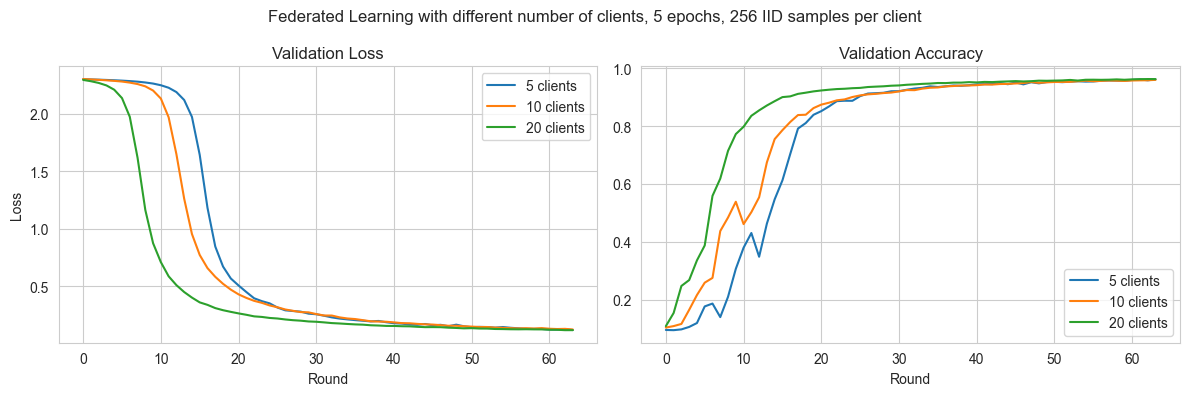

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# set grid
sns.set_style('whitegrid')

# plot the losses and accuracies
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(loss_5e5c, label='5 clients')
axs[0].plot(loss_5e10c, label='10 clients')
axs[0].plot(loss_5e20c, label='20 clients')
axs[0].set_title('Validation Loss')
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(acc_5e5c, label='5 clients')
axs[1].plot(acc_5e10c, label='10 clients')
axs[1].plot(acc_5e20c, label='20 clients')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Round')
axs[1].legend()

# set super title
plt.suptitle('Federated Learning with different number of clients, 5 epochs, 256 IID samples per client')
# add some space between the plots
plt.tight_layout()

plt.show()



### Brief comment on the results of this experiment

This results show how all configurations were able to reach satisfying performances and, as I was expecting, the higher the number of the clients, the higher the faster the convergence. However, all models will eventually converge to a stable point. The results are quite good and impressing, considering the low number of data points sampled by each client and the simplicity of the tested CNN used.
We will now proceed to assess performance of all the models in different scenarios in what the original paper refers to as "pathological" non IID scenarios.